In [64]:
import torch
import matplotlib.pyplot as plt
from xitorch.optimize import rootfinder

from torchquad import Simpson, MonteCarlo, set_up_backend

import sys
sys.path.append('..')
from hijacobi import Task, Spherically_Symmetric, bisection, reparam

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [65]:
# Setting model
metric_f = lambda r: 1-2/r
BH = Spherically_Symmetric(f=metric_f)

# Setting up solver
Solver0 = reparam(BH)
Solver0.set_Simpson()
Solver0.setup(2.4, 1e-4, 40, 31)
Solver0.setCustomIth(BH.Ith)

# Setting up task
th_s = torch.pi/2
th_obs = torch.pi*17/180

r_s = torch.Tensor([2.02, 2.4, 2.8, 3, 3.5, 5, 8, 9])
r_obs = 50

ic_0 = torch.Tensor([[[th_s, th_obs], [r_, r_obs]]for r_ in r_s ])

Task0 = Task(BH, [[0, 0, ic_0], [1, 0, ic_0]])
Task0.set_solver(Solver0)

Test passed, setting fuction as Ith


In [44]:
def make_gma(gma_min, gma_max, N, s):
    xspan = torch.linspace(-0.9999, 0.999, N)
    ticks = xspan/(1+torch.pow(abs(xspan), s))
    
    return (gma_min+gma_max)/2 + (gma_max - gma_min)*ticks

print(make_gma(-1.4, 1.4, 21, 1.3))

tensor([-1.3995, -1.3456, -1.2808, -1.2026, -1.1085, -0.9950, -0.8584, -0.6942,
        -0.4981, -0.2664,  0.0000,  0.2664,  0.4981,  0.6942,  0.8584,  0.9950,
         1.1085,  1.2026,  1.2808,  1.3456,  1.3995])


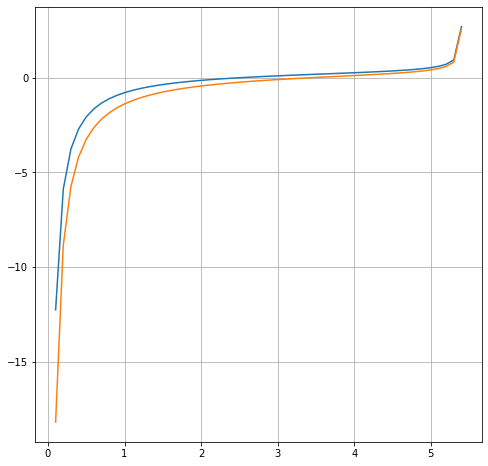

In [15]:
eq0 = Task0.make_eq(0, 0)
eq1 = Task0.make_eq(1, 0)

eq_1q = lambda q, l: eq1(l, q)
eq_0q = lambda q, l: eq0(l, q)

q0 = torch.linspace(0, 6, 61)
l0 = torch.ones_like(q0)*0

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(q0, eq0(l0, q0))
ax.plot(q0, eq1(l0, q0))
ax.grid('on')
plt.show()

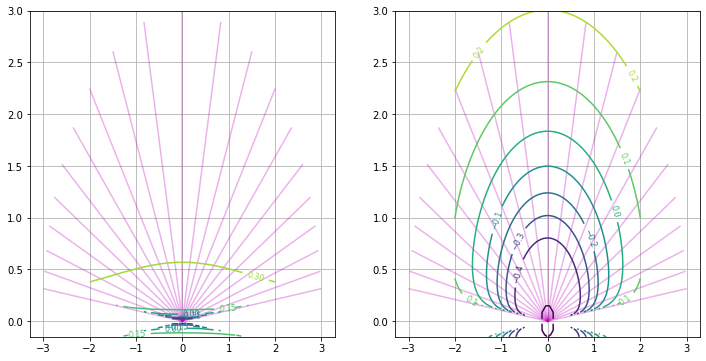

In [19]:


l_lim = 2
q_lim = 3
l_s = torch.linspace(-l_lim, l_lim, 201)
q_s = torch.linspace(-0.05*q_lim, q_lim, 201)
l_g, q_g = torch.meshgrid(l_s, q_s, indexing='ij')

r_n = 4
er0 = Task0.make_eq(0, r_n)(l_g, q_g)
er1 = Task0.make_eq(1, r_n)(l_g, q_g)

p_span = torch.linspace(0, 3, 3)
gma_span = make_gma(-th_obs, th_obs, 21, 1.3)

p_grid, gma_grid = torch.meshgrid(p_span, gma_span)

l_grid = p_grid*torch.sin(gma_grid)
q_grid = p_grid*torch.cos(gma_grid)

fig, ax = plt.subplots(1,2, figsize=(12, 6))

im0 = torch.sigmoid(er0)-0.5
im1 = torch.sigmoid(er1)-0.5

ax[0].plot(l_grid, q_grid, 'm', alpha=0.3)
CS0 = ax[0].contour(l_g, q_g, im0)
ax[0].clabel(CS0, inline=True, fontsize=8)
ax[0].grid('on')

ax[1].plot(l_grid, q_grid, 'm', alpha=0.3)
CS1 = ax[1].contour(l_g, q_g, im1)
ax[1].clabel(CS1, inline=True, fontsize=8)
ax[1].grid('on')

plt.show()

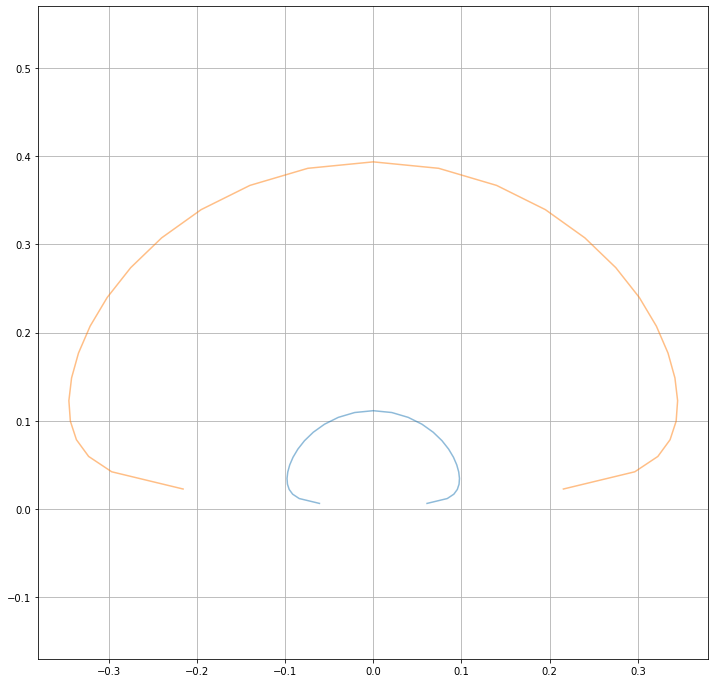

In [63]:
th_s = torch.pi/2
th_obs = torch.pi*84/180

r_s = torch.Tensor([2.02, 2.4, 2.8, 3, 3.8, 4, 4.2, 4.4, 4.6])
r_obs = 10000

ic_0 = torch.Tensor([[[th_s, th_obs], [r_, r_obs]]for r_ in r_s ])

Task0 = Task(BH, [[0, 0, ic_0], [1, 0, ic_0]])
Task0.set_solver(Solver0)

n = 1

eq0 = Task0.make_eq(1, 0)
eq1 = Task0.make_eq(1, 4)

l_f = lambda p, gma: p*torch.sin(gma)
q_f = lambda p, gma: p*torch.cos(gma)

eq_0p = lambda p, gma: eq0(l_f(p, gma), q_f(p, gma))
eq_1p = lambda p, gma: eq1(l_f(p, gma), q_f(p, gma))


# l_g, q_g = torch.meshgrid(lspan, qspan, indexing='ij')

# er0 = eq0(l_g, q_g)
# er1 = eq1(l_g, q_g)  

rngN = 31
gma_span = make_gma(-th_obs, th_obs, rngN, 1.3)
p_min = torch.ones(rngN)*1e-5
p_max = torch.ones(rngN)*2

p0 = bisection(eq_0p, p_min, p_max, gma_span, tol=1e-5, maxiter=20)
p1 = bisection(eq_1p, p_min, p_max, gma_span, tol=1e-5, maxiter=20)

# z = torch.zeros_like(lspan)
# tol0 = torch.less(abs(eq0(lspan, q0)), 1e-3)
# tol1 = torch.less(abs(eq1(lspan, q1)), 1e-3)

fig, ax = plt.subplots(1,1, figsize=(12, 12))

ax.plot(l_f(p0, gma_span), q_f(p0, gma_span), alpha=0.5)
ax.plot(l_f(p1, gma_span), q_f(p1, gma_span), alpha=0.5)
ax.grid('on')
ax.axis('equal')

# CS0 = ax.contour(l_g, q_g, er0)
# ax.clabel(CS0, inline=True, fontsize=8)
# CS0 = ax.contour(l_g, q_g, er1)
# ax.clabel(CS0, inline=True, fontsize=8)

# ax.plot(lspan[tol0], q0[tol0], 'x')
# ax.plot(lspan[tol1], q1[tol1], 'x')  
# ax.grid('on')

plt.show()
